# Jigsaw Puzzle — Milestone 1 Pipeline

This notebook implements a full Milestone-1 pipeline for the puzzle dataset located at `/mnt/data/1.jpg`.

**Features implemented:**
- Automatic grid detection (projection profiles) with fallback to manual grid size
- Tile extraction for 2x2, 4x4, 8x8 puzzles
- Per-tile enhancement (denoise, CLAHE, optional resize)
- Binary mask creation and contour extraction
- Artifacts saving (enhanced images, masks, contours, metadata)
- Visualization helpers (before/after and grid overlay)

Run each cell in order. Modify parameters near the top if needed.


In [4]:

# Imports and parameters
import cv2, os, json, numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

INPUT_PATH = "D:/Image-Processing-Project/Gravity_Falls/puzzle_2x2/1.jpg"   # representative image
OUT_DIR = "D:/Image-Processing-Project/output"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"tiles"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"visualizations"), exist_ok=True)

# Parameters (tweak if needed)
FALLBACK_GRID = None   # set to (rows,cols) if auto-detect fails, e.g. (4,4)
PADDING = 4            # pixels to include around tiles when cropping
RESIZE_TO = None       # set e.g. (256,256) to resize tiles for uniformity, or None to keep original
SAVE_CONTOUR_NPY = True


In [5]:

# ============================  
# USER SETTINGS
# ============================
IMAGE_PATH = "D:/Image-Processing-Project/Gravity_Falls/puzzle_4x4/15.jpg"
# Optional: set GRID_SIZE manually or leave None to infer automatically
GRID_SIZE = None

# ============================
# OUTPUT FOLDERS
# ============================
BASE_OUTPUT = "D:/Image-Processing-Project/output"
TILES_DIR = os.path.join(BASE_OUTPUT, "tiles")
CONTOURS_DIR = os.path.join(BASE_OUTPUT, "contours")
EDGES_DIR = os.path.join(BASE_OUTPUT, "edges")
VIZ_DIR = os.path.join(BASE_OUTPUT, "visualizations")

os.makedirs(TILES_DIR, exist_ok=True)
os.makedirs(CONTOURS_DIR, exist_ok=True)
os.makedirs(EDGES_DIR, exist_ok=True)
os.makedirs(VIZ_DIR, exist_ok=True)

# ============================
# LOAD IMAGE
# ============================
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise Exception("❌ Image not found! Check IMAGE_PATH.")

h, w, _ = img.shape

# ============================
# INFER GRID SIZE (if not specified)
# ============================
if GRID_SIZE is None:
    # Try to guess from folder name: look for 2x2, 4x4, 8x8
    folder_name = os.path.basename(os.path.dirname(IMAGE_PATH))
    if "2x2" in folder_name:
        GRID_SIZE = 2
    elif "4x4" in folder_name:
        GRID_SIZE = 4
    elif "8x8" in folder_name:
        GRID_SIZE = 8
    else:
        # Fallback: assume smallest 2x2
        GRID_SIZE = 2
print(f"Using GRID_SIZE = {GRID_SIZE}")

tile_h = h // GRID_SIZE
tile_w = w // GRID_SIZE

tile_count = 0
full_contour_img = img.copy()

# ============================
# GRID SEGMENTATION + TILE EXTRACTION
# ============================
for row in range(GRID_SIZE):
    for col in range(GRID_SIZE):
        y1, y2 = row * tile_h, (row + 1) * tile_h
        x1, x2 = col * tile_w, (col + 1) * tile_w

        tile = img[y1:y2, x1:x2]

        # Save tile
        tile_filename = f"tile_{tile_count}.png"
        cv2.imwrite(os.path.join(TILES_DIR, tile_filename), tile)

        # Edge extraction
        gray = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blur, 50, 150)
        edge_filename = f"edges_{tile_count}.png"
        cv2.imwrite(os.path.join(EDGES_DIR, edge_filename), edges)

        # Contour extraction
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour_img = tile.copy()
        cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
        contour_filename = f"contour_{tile_count}.png"
        cv2.imwrite(os.path.join(CONTOURS_DIR, contour_filename), contour_img)

        # Draw contours on full image
        for cnt in contours:
            cnt_offset = cnt + [x1, y1]
            cv2.drawContours(full_contour_img, [cnt_offset], -1, (0, 255, 0), 2)

        tile_count += 1

# ============================
# GRID VISUALIZATION IMAGE
# ============================
grid_viz = img.copy()
for i in range(1, GRID_SIZE):
    cv2.line(grid_viz, (0, i * tile_h), (w, i * tile_h), (0, 0, 255), 2)
    cv2.line(grid_viz, (i * tile_w, 0), (i * tile_w, h), (0, 0, 255), 2)

cv2.imwrite(os.path.join(VIZ_DIR, "grid_visualization.png"), grid_viz)

# Save original image with contours
cv2.imwrite(os.path.join(VIZ_DIR, "original_with_contours.png"), full_contour_img)

print("✅ Tile extraction completed.")
print("✅ Edge images saved in 'edges/' folder.")
print("✅ Contours extracted and saved in 'contours/' folder.")
print("✅ Original image with contours saved in 'visualizations/' folder.")
print("✅ Grid visualization saved in 'visualizations/' folder.")


Using GRID_SIZE = 4
✅ Tile extraction completed.
✅ Edge images saved in 'edges/' folder.
✅ Contours extracted and saved in 'contours/' folder.
✅ Original image with contours saved in 'visualizations/' folder.
✅ Grid visualization saved in 'visualizations/' folder.


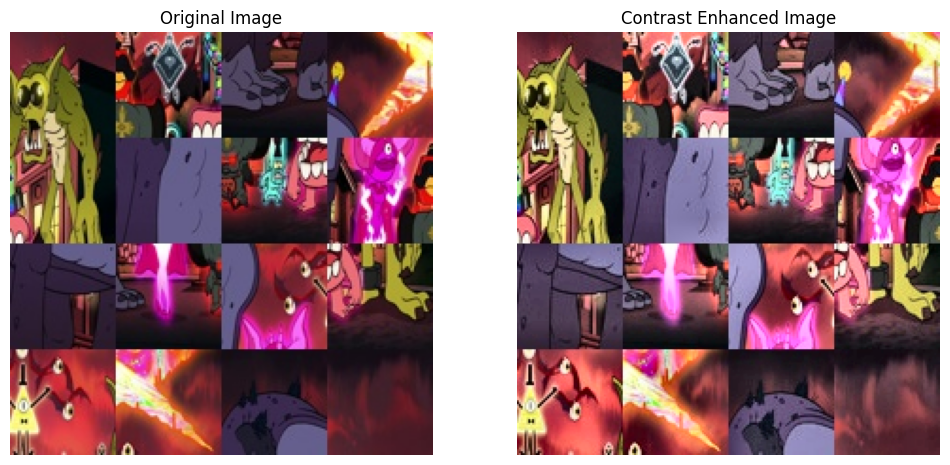

In [6]:


# ============================
# USER SETTINGS
# ============================

# ============================
# READ IMAGE
# ============================
img = cv2.imread(IMAGE_PATH)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ============================
# CONTRAST ENHANCEMENT (CLAHE)
# ============================
# Convert to LAB color space
lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab)

# Apply CLAHE to L-channel (lightness)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
l_enhanced = clahe.apply(l)

# Merge channels and convert back to RGB
lab_enhanced = cv2.merge((l_enhanced, a, b))
enhanced_img = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2RGB)

# ============================
# VISUALIZE ORIGINAL vs ENHANCED
# ============================
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(enhanced_img)
plt.title("Contrast Enhanced Image")
plt.axis("off")

plt.show()
